In [1]:
from Contour import ContourData

# Run with the subset test data

In [60]:
cd = ContourData(
        filepath = 'WellElevationSubsetSmaller.xlsx',
        xcol = 'X',
        ycol = 'Y',
        zcol = "Water Elevation(ft NAVD88)",
        tcol = "DateTimeRounded",
        crs = 2926,
        method = 'linear',
        steps = 50
)

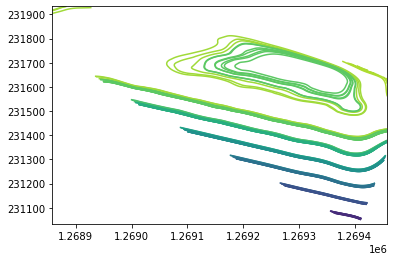

In [61]:
cd.subsetData()
cd.contourData(subdivisions=5)
cd.extractGeometry()
cd.mergeGeometry()
cd.reproject()
cd.toGeoJSON("test.json")

# Run on data with no Observation wells yet

In [131]:
cd = ContourData(
        filepath = 'WellElevations4hour.xlsx',
        xcol = 'X',
        ycol = 'Y',
        zcol = "Water Elevation(ft NAVD88)",
        tcol = "DateTimeRounded",
        crs = 2926,
        method = 'tri',
        
)

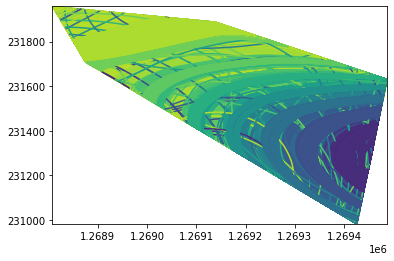

In [132]:
cd.subsetData()
cd.contourData(subdivisions=5)
cd.extractGeometry()
cd.mergeGeometry()
cd.reproject()
cd.toGeoJSON("Contours4hour.json")

# GPR Testing

In [2]:
cd = ContourData(
        filepath = 'WellElevationSubsetSmaller.xlsx',
        xcol = 'X',
        ycol = 'Y',
        zcol = "Water Elevation(ft NAVD88)",
        tcol = "DateTimeRounded",
        crs = 2926,
        method = 'gpr',
        steps = 10
)

C:\Users\tmetos\Documents\GitHub\contouring\Contour.py:250: UserWarning: No contour levels were found within the data range.
  cs = plt.tricontour(tri_refi, z_test_refi, levels=vals)


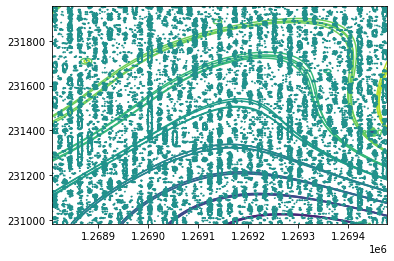

In [4]:
cd.subsetData()
cd.contourData(subdivisions=3)
cd.extractGeometry()
cd.mergeGeometry()
cd.reproject()
cd.toGeoJSON("gpr2.json")

In [5]:
cd.dfContours['DataFrames'].iloc[0]

,DateTime,DateTimeRounded,Water Elevation(ft NAVD88),X,Y,Location_ID,DateTimeWellCount
0,2019-12-21 00:01:15,2019-12-21,17.1598,1.268875e+06,231708.378574,FMW-129,7
8,2019-12-21 00:01:55,2019-12-21,17.2914,1.269488e+06,231629.160770,FMW-131,7
16,2019-12-21 00:02:58,2019-12-21,17.1470,1.269447e+06,231392.408923,FMW-137,7
24,2019-12-20 23:58:39,2019-12-21,16.2040,1.269426e+06,230983.377850,FMW-138,7
32,2019-12-20 23:54:42,2019-12-21,17.1390,1.269139e+06,231886.615910,FMW-140,7
40,2019-12-20 23:58:58,2019-12-21,17.0785,1.268808e+06,231957.470073,FMW-141,7
48,2019-12-20 23:53:54,2019-12-21,16.9992,1.269359e+06,231666.083500,GEI-2,7


In [7]:
cd.dfContours['Surfaces'].iloc[0]

,X,Y,Water Elevation(ft NAVD88)
0,1.268808e+06,230983.37785,16.994298
1,1.268858e+06,230983.37785,16.994298
2,1.268908e+06,230983.37785,16.994298
3,1.268958e+06,230983.37785,16.994298
4,1.269008e+06,230983.37785,16.994298
...,...,...,...
275,1.269258e+06,231933.37785,16.994298
276,1.269308e+06,231933.37785,16.994298
277,1.269358e+06,231933.37785,16.994298
278,1.269408e+06,231933.37785,16.994298


In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import numpy as np
import matplotlib.pyplot as plt

sub = cd.dfContours['DataFrames'].iloc[0]

x = sub["X"].values
y = sub["Y"].values
z = sub["Water Elevation(ft NAVD88)"].values

X = np.array([x,y]).T
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
grid_x, grid_y = np.meshgrid(np.arange(xmin,xmax,50), np.arange(ymin,ymax,50))
gfx = grid_x.flatten()
gfy = grid_y.flatten()
grid = np.array([gfx,gfy]).T

# fit/predict GPR 
kernel = RBF() + ConstantKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0,n_restarts_optimizer=50).fit(X, z)

gfz = gpr.predict(grid)

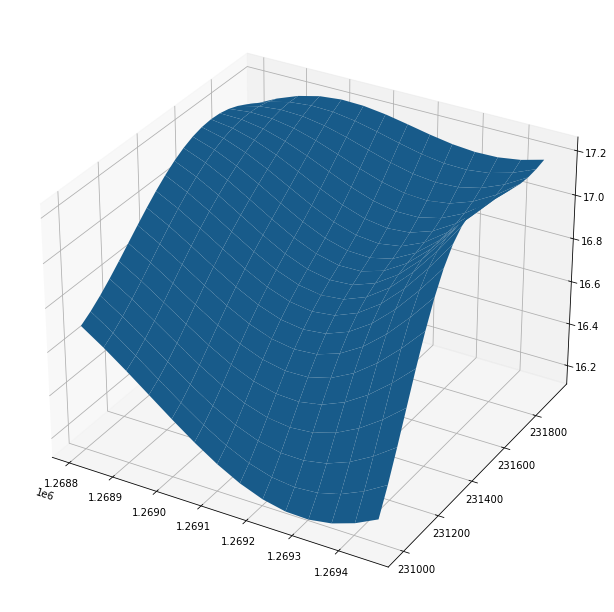

In [31]:

fig = plt.figure(figsize=(11,11))
ax = fig.gca(projection='3d')
ax.plot_surface(grid_x,grid_y,gfz.reshape(grid_y.shape))

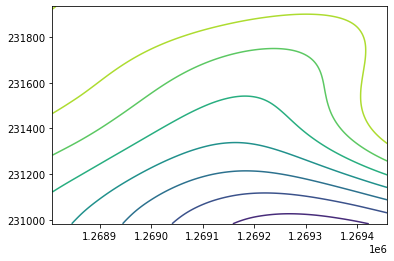

In [35]:
import matplotlib.tri as tri
triang = tri.Triangulation(gfx, gfy)
refiner = tri.UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(gfz, subdiv=4)

cs = plt.tricontour(tri_refi, z_test_refi, levels=None)